### 1. Problem Statement
a deep 3D-CNN is proposed to predict the anisotropic effective material properties for RVE with random inclusions.

ref. Three-dimensional convolutional neural network (3D-CNN) for heterogeneous material homogenization

### 2. Data extraction
### 3. Data scaling
### 4. Model tuning
### 5. Model serving (if applicable)

In [1]:
import numpy as np
import scipy.io
import keras
import random
import time
import gc
import os
import matplotlib.pyplot as plt
from random import shuffle
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dropout, Dense
from keras.optimizers import RMSprop, Adagrad, Adadelta, Adam, Adamax, Nadam, SGD, TFOptimizer
from keras.layers import Conv3D, MaxPooling3D, TimeDistributed, Flatten, LSTM, Reshape, BatchNormalization, Activation, UpSampling1D, ZeroPadding1D, PReLU
from sklearn.preprocessing import MinMaxScaler
from keras.models import load_model

In [2]:
# set environment
os.environ['CUDA_VISIBLE_DEVICES'] = '0'  # CPU:-1; GPU0: 1; GPU1: 0;

### 2. Data Extraction

In [3]:
########### Load dataset {(x,y)} from multiple files #############
dataDir = "../data/"
X_data1 = scipy.io.loadmat(dataDir + 'phase_2nd_0_199.mat')['phase']
X_data2 = scipy.io.loadmat(dataDir + 'phase_2nd_200_399.mat')['phase']
X_data3 = scipy.io.loadmat(dataDir + 'phase_3rd_0_199.mat')['phase']
X_data4 = scipy.io.loadmat(dataDir + 'phase_3rd_200_399.mat')['phase']
X_data5 = scipy.io.loadmat(dataDir + 'phase_3rd_400_599.mat')['phase']
X_data6 = scipy.io.loadmat(dataDir + 'phase_3rd_600_799.mat')['phase']
X_data7 = scipy.io.loadmat(dataDir + 'phase_3rd_800_999.mat')['phase']
X_data8 = scipy.io.loadmat(dataDir + 'phase_3rd_1000_1199.mat')['phase']
# X_data9 = scipy.io.loadmat(dataDir + 'phase_3rd_1200_1399.mat')['phase']
# X_data10 = scipy.io.loadmat(dataDir + 'phase_3rd_1400_1599.mat')['phase']

MemoryError: 

In [ ]:
# method 2: datatype conversions
X_data1 = X_data1.astype('bool')
X_data2 = X_data2.astype('bool')
X_data3 = X_data3.astype('bool')
X_data4 = X_data4.astype('bool')
X_data5 = X_data5.astype('bool')
X_data6 = X_data6.astype('bool')
X_data7 = X_data7.astype('bool')
X_data8 = X_data8.astype('bool')
# X_data9 = X_data9.astype('bool')
# X_data10 = X_data10.astype('bool')

In [ ]:
X_data = np.concatenate([X_data1, X_data2, X_data3, X_data4, X_data5,
                         X_data6, X_data7, X_data8])
X_data = np.reshape(X_data, [X_data.shape[0], X_data.shape[1], X_data.shape[2], X_data.shape[3], 1])

In [ ]:
# method 1: delete unused data
del [[X_data1, X_data2, X_data3, X_data4, X_data5, X_data6, X_data7, X_data8]]
gc.collect()

In [ ]:
y_data1 = scipy.io.loadmat(dataDir + 'label_2nd.mat')['label']
y_data2 = scipy.io.loadmat(dataDir + 'label_3rd.mat')['label']
y_data = np.concatenate([y_data1, y_data2[0:1200]])

In [ ]:
del [[y_data1, y_data2]]
gc.collect()

### 3. Data Scaling

In [10]:
########### Scale data through MinMaxScaler ############
########### E, v (mu) are scaled separately ############
########### E_data -> E_data_map            ############
E_data = y_data[:, 0:6]
E_data_flatten = np.reshape(E_data, [E_data.shape[0], E_data.shape[1]])
scaler_E = MinMaxScaler(feature_range=(0, 1))
scaler_E.fit(E_data_flatten)
E_data_flatten_map = scaler_E.transform(E_data_flatten)
E_data_map = np.reshape(E_data_flatten_map, [E_data.shape[0], E_data.shape[1]])

v_data = y_data[:, 6:]
v_data_flatten = np.reshape(v_data, [v_data.shape[0], v_data.shape[1]])
scaler_v = MinMaxScaler(feature_range=(0, 1))
scaler_v.fit(v_data_flatten)
v_data_flatten_map = scaler_v.transform(v_data_flatten)
v_data_map = np.reshape(v_data_flatten_map, [v_data.shape[0], v_data.shape[1]])
y_data_map = np.concatenate([E_data_map, v_data_map], axis=1)

In [11]:
# Input shape, output shape
input_shape = X_data.shape[1:]
num_classes = y_data.shape[-1]  # number of output features
batch_size = 5
print(input_shape, num_classes)

(101, 101, 101, 1) 12


### 4. Model Tuning

In [12]:
adam = Adam(learning_rate=0.0001)
model = Sequential()
model.add(Conv3D(16, 5, strides=1, padding='valid', use_bias=True, input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Conv3D(16, 5, strides=1, padding='valid', use_bias=True, input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Conv3D(32, 3, strides=1, padding='valid', use_bias=True))
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Flatten())
model.add(Dense(128))
model.add(Dense(64))
model.add(Dense(num_classes))

model.summary()
model.compile(loss='mean_squared_error',
              optimizer=adam,                # RMSprop(), Adagrad, Nadam, Adagrad, Adadelta, Adam, Adamax,
              metrics=['mse', 'mape'])
best_loss = 100
train_loss = []
val_loss = []
history = []

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 97, 97, 97, 16)    2016      
                                                                 
 activation (Activation)     (None, 97, 97, 97, 16)    0         
                                                                 
 max_pooling3d (MaxPooling3D  (None, 48, 48, 48, 16)   0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 46, 46, 46, 32)    13856     
                                                                 
 activation_1 (Activation)   (None, 46, 46, 46, 32)    0         
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 23, 23, 23, 32)   0         
 3D)                                                    

In [14]:
#with tf.device('/device:CPU:0'):
with tf.device('/device:GPU:0'):

    config = tf.compat.v1.ConfigProto()
    config.gpu_options.allow_growth = True
    session = tf.compat.v1.Session(config=config)

    start = time.time()

    # Load pre-trained model if exists
    model = load_model("../saved_models/model1.h5")

    ######### Randomly shuffle the data set  ##########
    ######### split them into train/val/test ##########
    random.seed(4)
    Ind = list(range(len(X_data)))
    shuffle(Ind)
    ratio_split = 0.7
    
    epochs = 5
    for e in range(epochs):
        print('epoch = ', e + 1)
        
        Ind_tr = Ind[0:round(ratio_split * len(Ind))]
        Ind_val = Ind[round(ratio_split * len(Ind)):round(0.85 * len(Ind))]
        Ind_test = Ind[round(0.85 * len(Ind)):]
    
        X_train = X_data[Ind_tr]
        y_train_map = y_data_map[Ind_tr]
        X_val = X_data[Ind_val]
        y_val_map = y_data_map[Ind_val]
        
        model.fit(X_train, y_train_map,
                  batch_size=batch_size,
                  # validation_split=0.2,
                  validation_data=(X_val, y_val_map),
                  shuffle=True,
                  epochs=1)
        score0 = model.evaluate(X_train, y_train_map, batch_size=batch_size, verbose=0)
        score = model.evaluate(X_val, y_val_map, batch_size=batch_size, verbose=0)
        train_loss.append(score0[0])
        val_loss.append(score[0])

        if val_loss[e] < best_loss:
            best_loss = val_loss[e]
            model.save("../saved_models/model1_best.h5")

    end = time.time()
    running_time = end - start
    print('Running Time: ', running_time, ' sec')


epoch =  1
280/280 [==============================] - 3862s 14s/step - loss: 0.8538 - mse: 0.8538 - val_loss: 0.0582 - val_mse: 0.0582
epoch =  2
280/280 [==============================] - 3750s 13s/step - loss: 0.0840 - mse: 0.0840 - val_loss: 0.0179 - val_mse: 0.0179
epoch =  3
280/280 [==============================] - 3761s 13s/step - loss: 0.0622 - mse: 0.0622 - val_loss: 0.0136 - val_mse: 0.0136
epoch =  4
280/280 [==============================] - 3707s 13s/step - loss: 0.0574 - mse: 0.0574 - val_loss: 0.0142 - val_mse: 0.0142
epoch =  5
280/280 [==============================] - 3707s 13s/step - loss: 0.0531 - mse: 0.0531 - val_loss: 0.0119 - val_mse: 0.0119
Running Time:  21483.90820837021  sec


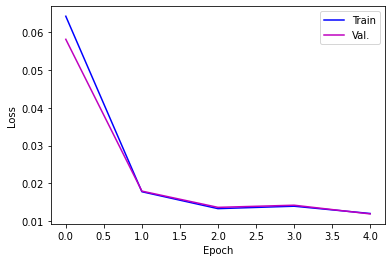

In [15]:
# Plot the history of loss
fig, ax = plt.subplots()
ax.plot(np.array(train_loss), 'b-', label='Train')
ax.plot(np.array(val_loss), 'm-', label='Val.')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend()
plt.show()

In [16]:
# Retrieve the model for model inference
model_best = load_model("../saved_models/model.h5")

In [17]:
# Get the inference results on testing data
X_test = X_data[Ind_test]
y_test = y_data[Ind_test]

In [ ]:
# Get the inference runtime
start = time.time()
y_test_pred_map = model_best.predict(X_test)
E_test_pred = scaler_E.inverse_transform(y_test_pred_map[:, 0:6])
v_test_pred = scaler_v.inverse_transform(y_test_pred_map[:, 6:])
y_test_pred = np.concatenate([E_test_pred, v_test_pred], axis=1)
end = time.time()
running_time = end - start
print('Running Time: ', running_time, ' sec')

In [ ]:
# Mean absolute relative error on testing data
ARE = np.absolute(y_test_pred-y_test)/y_test
MARE = np.mean(ARE, axis=0)

In [ ]:
# plot prediction vs. truth
def Pred_vs_truth(Emin, Emax, Vmin, Vmax, y_pred, y_truth):

    fig, ax = plt.subplots(nrows=4, ncols=3, figsize=(12, 16))
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    fig.text(0.5, 0.04, 'Prediction', ha='center',fontsize=20)
    fig.text(0.04, 0.5, 'Ground truth', va='center', rotation='vertical',fontsize=20)

    E11_pred = y_pred[:,0]
    E11_truth = y_truth[:,0]
    cf = ax[0, 0].scatter(E11_pred, E11_truth, alpha=0.5, label='$E_{11}$', edgecolors='none',facecolor='blue', s=10)
    ax[0, 0].axis('square')
    ax[0, 0].plot(ax[0, 0].get_xlim(), ax[0, 0].get_ylim(), label='Baseline', color='firebrick', ls="-", alpha=0.7)
    # ax[0, 0].set_xlim([Emin, Emax])
    # ax[0, 0].set_ylim([Emin, Emax])
    ax[0, 0].set_title('$E_{11}$')
    ax[0, 0].grid(True)
    ax[0, 0].legend()

    E22_pred = y_pred[:,1]
    E22_truth = y_truth[:,1]
    cf = ax[0, 1].scatter(E22_pred, E22_truth, alpha=0.5, label='$E_{22}$', edgecolors='none',facecolor='blue', s=10)
    ax[0, 1].axis('square')
    ax[0, 1].plot(ax[0, 1].get_xlim(), ax[0, 1].get_ylim(), label='Baseline', color='firebrick', ls="-", alpha=0.7)
    # ax[0, 0].set_xlim([Emin, Emax])
    # ax[0, 0].set_ylim([Emin, Emax])
    ax[0, 1].set_title('$E_{22}$')
    ax[0, 1].grid(True)
    ax[0, 1].legend()

    E33_pred = y_pred[:,2]
    E33_truth = y_truth[:,2]
    cf = ax[0, 2].scatter(E33_pred, E33_truth, alpha=0.5, label='$E_{33}$', edgecolors='none',facecolor='blue', s=10)
    ax[0, 2].axis('square')
    ax[0, 2].plot(ax[0, 2].get_xlim(), ax[0, 2].get_ylim(), label='Baseline', color='firebrick', ls="-", alpha=0.7)
    # ax[0, 0].set_xlim([Emin, Emax])
    # ax[0, 0].set_ylim([Emin, Emax])
    ax[0, 2].set_title('$E_{33}$')
    ax[0, 2].grid(True)
    ax[0, 2].legend()

    G23_pred = y_pred[:,3]
    G23_truth = y_truth[:,3]
    cf = ax[1, 0].scatter(G23_pred, G23_truth, alpha=0.5, label='$G_{23}$', edgecolors='none',facecolor='blue', s=10)
    ax[1, 0].axis('square')
    ax[1, 0].plot(ax[1, 0].get_xlim(), ax[1, 0].get_ylim(), label='Baseline', color='firebrick', ls="-", alpha=0.7)
    # ax[0, 1].set_xlim([20, 50])
    # ax[0, 1].set_ylim([20, 50])
    ax[1, 0].set_title('$G_{23}$')
    ax[1, 0].grid(True)
    ax[1, 0].legend()

    G13_pred = y_pred[:,4]
    G13_truth = y_truth[:,4]
    cf = ax[1, 1].scatter(G13_pred, G13_truth, alpha=0.5, label='$G_{13}$', edgecolors='none',facecolor='blue', s=10)
    ax[1, 1].axis('square')
    ax[1, 1].plot(ax[1, 1].get_xlim(), ax[1, 1].get_ylim(), label='Baseline', color='firebrick', ls="-", alpha=0.7)
    # ax[0, 1].set_xlim([20, 50])
    # ax[0, 1].set_ylim([20, 50])
    ax[1, 1].set_title('$G_{13}$')
    ax[1, 1].grid(True)
    ax[1, 1].legend()

    G12_pred = y_pred[:,5]
    G12_truth = y_truth[:,5]
    cf = ax[1, 2].scatter(G12_pred, G12_truth, alpha=0.5, label='$G_{12}$', edgecolors='none',facecolor='blue', s=10)
    ax[1, 2].axis('square')
    ax[1, 2].plot(ax[1, 2].get_xlim(), ax[1, 2].get_ylim(), label='Baseline', color='firebrick', ls="-", alpha=0.7)
    # ax[0, 1].set_xlim([20, 50])
    # ax[0, 1].set_ylim([20, 50])
    ax[1, 2].set_title('$G_{12}$')
    ax[1, 2].grid(True)
    ax[1, 2].legend()

    v21_pred = y_pred[:,6]
    v21_truth = y_truth[:,6]
    cf = ax[2, 0].scatter(v21_pred, v21_truth, alpha=0.5, label=r'$\nu_{21}$', edgecolors='none',facecolor='blue', s=10)
    ax[2, 0].axis('square')
    ax[2, 0].set_xlim([0.26, 0.34])
    ax[2, 0].set_ylim([0.26, 0.34])
    ax[2, 0].plot(ax[2, 0].get_xlim(), ax[2, 0].get_ylim(), label='Baseline', color='firebrick', ls="-", alpha=0.7)
    ax[2, 0].set_title(r'$\nu_{21}$')
    ax[2, 0].grid(True)
    ax[2, 0].legend()

    v31_pred = y_pred[:,7]
    v31_truth = y_truth[:,7]
    cf = ax[2, 1].scatter(v31_pred, v31_truth, alpha=0.5, label=r'$\nu_{31}$', edgecolors='none',facecolor='blue', s=10)
    ax[2, 1].axis('square')
    ax[2, 1].set_xlim([0.26, 0.34])
    ax[2, 1].set_ylim([0.26, 0.34])
    ax[2, 1].plot(ax[2, 1].get_xlim(), ax[2, 1].get_ylim(), label='Baseline', color='firebrick', ls="-", alpha=0.7)
    ax[2, 1].set_title(r'$\nu_{31}$')
    ax[2, 1].grid(True)
    ax[2, 1].legend()

    v12_pred = y_pred[:, 8]
    v12_truth = y_truth[:, 8]
    cf = ax[2, 2].scatter(v12_pred, v12_truth, alpha=0.5, label=r'$\nu_{12}$', edgecolors='none', facecolor='blue',s=10)
    ax[2, 2].axis('square')
    ax[2, 2].set_xlim([0.26, 0.34])
    ax[2, 2].set_ylim([0.26, 0.34])
    ax[2, 2].plot(ax[2, 2].get_xlim(), ax[2, 2].get_ylim(), label='Baseline', color='firebrick', ls="-", alpha=0.7)
    ax[2, 2].set_title(r'$\nu_{12}$')
    ax[2, 2].grid(True)
    ax[2, 2].legend()

    v32_pred = y_pred[:,9]
    v32_truth = y_truth[:,9]
    cf = ax[3, 0].scatter(v32_pred, v32_truth, alpha=0.5, label=r'$\nu_{32}$', edgecolors='none',facecolor='blue', s=10)
    ax[3, 0].axis('square')
    ax[3, 0].set_xlim([0.26, 0.34])
    ax[3, 0].set_ylim([0.26, 0.34])
    ax[3, 0].plot(ax[3, 0].get_xlim(), ax[3, 0].get_ylim(), label='Baseline', color='firebrick', ls="-", alpha=0.7)
    ax[3, 0].set_title(r'$\nu_{32}$')
    ax[3, 0].grid(True)
    ax[3, 0].legend()

    v13_pred = y_pred[:,10]
    v13_truth = y_truth[:,10]
    cf = ax[3, 1].scatter(v13_pred, v13_truth, alpha=0.5, label=r'$\nu_{13}$', edgecolors='none',facecolor='blue', s=10)
    ax[3, 1].axis('square')
    ax[3, 1].set_xlim([0.26, 0.34])
    ax[3, 1].set_ylim([0.26, 0.34])
    ax[3, 1].plot(ax[3, 1].get_xlim(), ax[3, 1].get_ylim(), label='Baseline', color='firebrick', ls="-", alpha=0.7)
    ax[3, 1].set_title(r'$\nu_{13}$')
    ax[3, 1].grid(True)
    ax[3, 1].legend()

    v23_pred = y_pred[:, 11]
    v23_truth = y_truth[:, 11]
    cf = ax[3, 2].scatter(v23_pred, v23_truth, alpha=0.5, label=r'$\nu_{23}$', edgecolors='none', facecolor='blue',s=10)
    ax[3, 2].axis('square')
    ax[3, 2].set_xlim([0.26, 0.34])
    ax[3, 2].set_ylim([0.26, 0.34])
    ax[3, 2].plot(ax[3, 2].get_xlim(), ax[3, 2].get_ylim(), label='Baseline', color='firebrick', ls="-", alpha=0.7)
    ax[3, 2].set_title(r'$\nu_{23}$')
    ax[3, 2].grid(True)
    ax[3, 2].legend()

    plt.savefig('../gallery/Pred_vs_Truth.pdf', dpi=400)
    plt.close('all')

In [ ]:
# Plot the prediction vs ground truth on testing data
Pred_vs_truth(60, 140, 0.25, 0.35, y_test_pred, y_test)